## Introduction

In the last lesson, you learned how to plot multiple graphs in a single figure using the `subplot` function. Given the handful of plotting functions we learned in the previous lessons and the newly learned subplotting ability we picked up in the last lesson, we have everything we need to put together a very powerful, and visually impressive, visualization called a scatterplot matrix. A [scatterplot matrix][1] is exactly what you'd think it is: a matrix of scatterplots. Where a scatterplot is useful for visualizing relationships between variables in our data, a scatterplot matrix allows us to to see the relationships between every pair of variables in our data. 

In this lesson, we'll see how to pull together everything we've learned thus far, to create a simple scatterplot matrix function.

[1]: http://www.r-bloggers.com/scatterplot-matrices/

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Getting the Data

In this lesson, we'll once again be using the [Iris data set][1] to test out our new visualization function. The code below is exactly the same as the code in previous lessons to download and load the data from the [UCI Machine Learning Repository][2].

[1]: https://en.wikipedia.org/wiki/Iris_flower_data_set
[2]: https://archive.ics.uci.edu/ml/datasets/Iris

In [7]:
import csv
import urllib2
from collections import namedtuple

# Create a namedtuple constructor for each record in the Iris data
#    1. sepal length in cm
#    2. sepal width in cm
#    3. petal length in cm
#    4. petal width in cm
#    5. class: 
#       -- Iris-setosa
#       -- Iris-versicolour
#       -- Iris-virginica
fields = ('sepal_length', 
          'sepal_width', 
          'petal_length', 
          'petal_width', 
          'species')
IrisRecord = namedtuple('IrisRecord', fields)

# Download and read in the data from the UCI Machine Learning Repository
response = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
iris_data_csv = response.read().strip()

# Convert each record into a format that's easier to work with (i.e.,
# wrap each record in the namedtuple that we created).
data = []
for row in csv.reader(iris_data_csv.splitlines()):
    data.append(IrisRecord(
        sepal_length          = float(row[0]),
        sepal_width           = float(row[1]),
        petal_length          = float(row[2]),
        petal_width           = float(row[3]),
        species               = row[4]))

## The `scatterplot_matrix` Function

The `scatterplot_matrix` function in the cell below, offers a very simple interface. It takes a 2D matrix of data, and an optional keyword argument `target`, which is just a boolean that specifies whether or not the matrix contains a column for the target variable. If the target parameter is `True`, which is the default value, then our function assumes that the last column in the matrix is the target variable and it will use the classes in that variable to color code the data in the matrix, otherwise, everything will be displayed in a single color.

The code on lines 16-34 should look pretty familiar to you by now. Lines 16-23, get the names of the features in our data if we used `namedtuples` to describe the data in our matrix. Line 27 gets the set of classes from our target variable, if there is one. Lines 30 and 31 create our color map dictionary. And, finally, line 34 creates the `Figure` object that we'll draw our scatterplot matrix in---it does so to specify a somewhat larger size for the matrix than the default.

Lines 37-58 are where the real work is done. In this bit of code, we loop through each feature in our data set, and for each feature, we loop through every feature again. This allows us to pair every feature in our data set with one another. Then on line 40, we call the `subplot` function to create the subplot for the next pair of features, and the code on lines 43-50 draw the current scatterplot. 

On the diagonal, we have a case where you would be plotting one feature against itself. Since this doesn't yield any useful information, we have two choices, we can either leave that cell blank, or we could do something with it. On lines 53-58 you can see that we've chosen to display a histogram for the current feature in that cell. This allows us to see the distribution of our data set for that feature and doesn't waste a single bit of space in our matrix.

After that, the rest of the code just cleans up each of the plots a bit, e.g., turning off x and y axis labels on the inner graphs, to make the entire visualization easier to read.

In [8]:
from itertools import cycle
from collections import defaultdict

def scatterplot_matrix(m, target=True):
    """Takes a MxN matrix and draws a scatterplot matrix
    
    This function assumes that each row in the matrix is 
    organized as features first, followed by the target 
    variable unless the target parameter is set to False.
    In that case, each row is considered to contain only
    features of the data.
    
    Keyword arguments:
    target -- if True, the last column in m is the target variable
    """
    try:
        # If each record is a namedtuple, get the list of fields;
        # we'll use those for the x- and y-axis labels of the 
        # scatterplot matrix. If target is True, don't get the
        # last field name.
        features = m[0]._fields[:-1] if target else m[0]._fields 
    except:
        features = range(len(m[0]) - 1) if target else range(len(m[0]))
        
    # If the matrix contains a target variables, create a list of classes
    if target:    
        classes = list(set(r[-1] for r in m))
        
    # Create a color map of species names to colors
    color_cycler = cycle(plt.rcParams['axes.prop_cycle'])
    cmap = defaultdict(lambda: next(color_cycler)['color'])
        
    # Set the size of the plot
    fig = plt.figure(figsize=(12, 12))
            
    # Loop through every feature and plot it against every feature
    for i, feature_row in enumerate(features):
        for j, feature_col in enumerate(features):
            # Create a new subplot
            plt.subplot(len(features), len(features), i*len(features)+j+1)
            
            # Plot the scatter plot for the current pair of features
            if i != j:
                x = [r[j] for r in m]
                y = [r[i] for r in m]
                if target:
                    c = [cmap[r[-1]] for r in m]
                else:
                    c = 'b'
                plt.scatter(x, y, edgecolors='w', c=c, linewidths=0.5)
            
            # Plot the histogram on the diagonal
            if target and i == j:
                df = [[r[i] for r in m if r[-1] == cls] for cls in classes]               
                colors = [cmap[cls] for cls in classes]
                plt.hist(df, color=colors, histtype='barstacked')
            elif i == j:
                plt.hist([r[i] for r in m], color='b', histtype='barstacked')
                                
            # Turn off the x-axis labels for everything but the last row
            if i < len(features) - 1:
                plt.tick_params(labelbottom='off')
            else:
                plt.xlabel(feature_col)
                
            # Turn off the y-axis labels for everything but the last column
            if j > 0:
                plt.tick_params(labelleft='off')
            else:
                plt.ylabel(feature_row)
            
            # Turn off all tick marks and make the label size 
            # a bit smaller than the default
            plt.tick_params(top='off', bottom='off', left='off', right='off', labelsize=8)

## Plotting the Iris Data Set

So, let's go ahead and give our `scatterplot_matrix` function a try by plotting the Iris data we read in a bit earlier in the lesson.

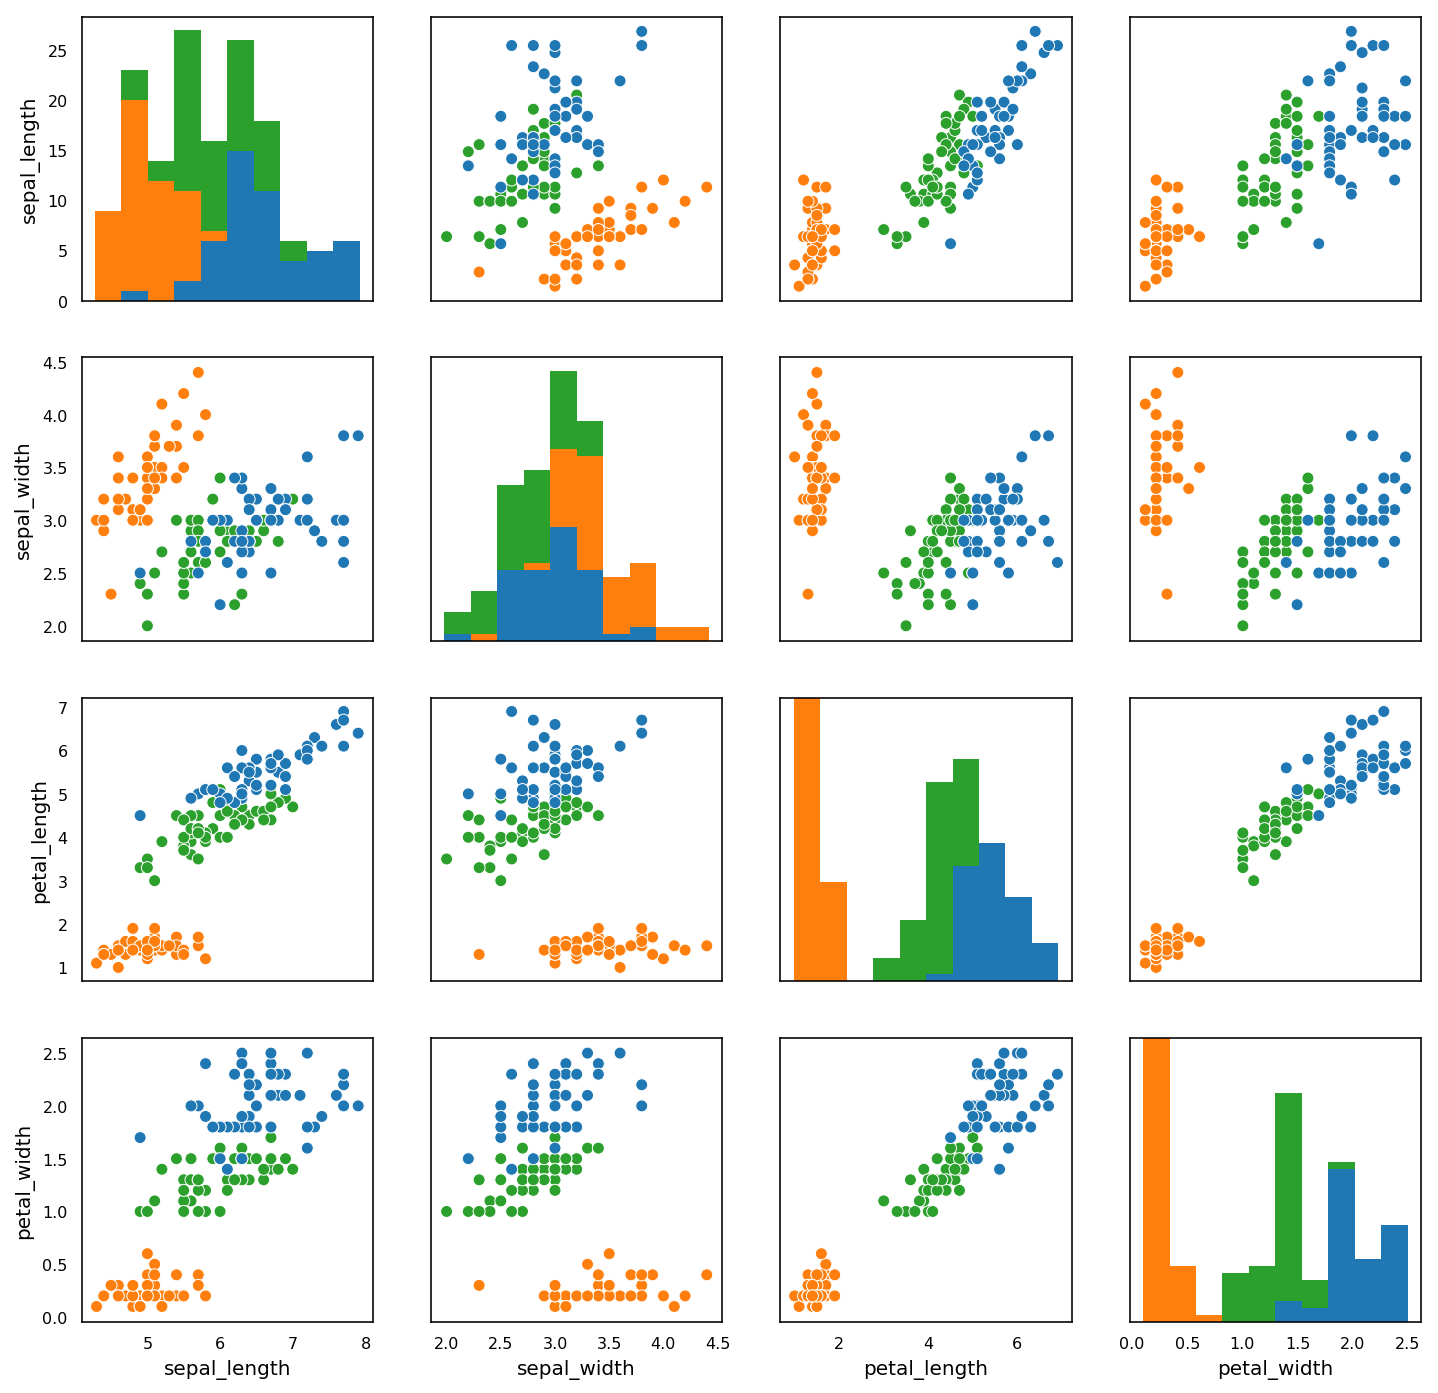

In [9]:
scatterplot_matrix(data)

Well, that looks positively fantastic, if I do say so myself, but what if we had a data set that didn't have a target attribute?

## Plotting a Data Set Without a Target

The code below uses the Iris data set again, but this time, we pass in everything but the last column, and we'll set the `target` parameter to `False` so we can see how our function works when there isn't a target variable in the data set. 

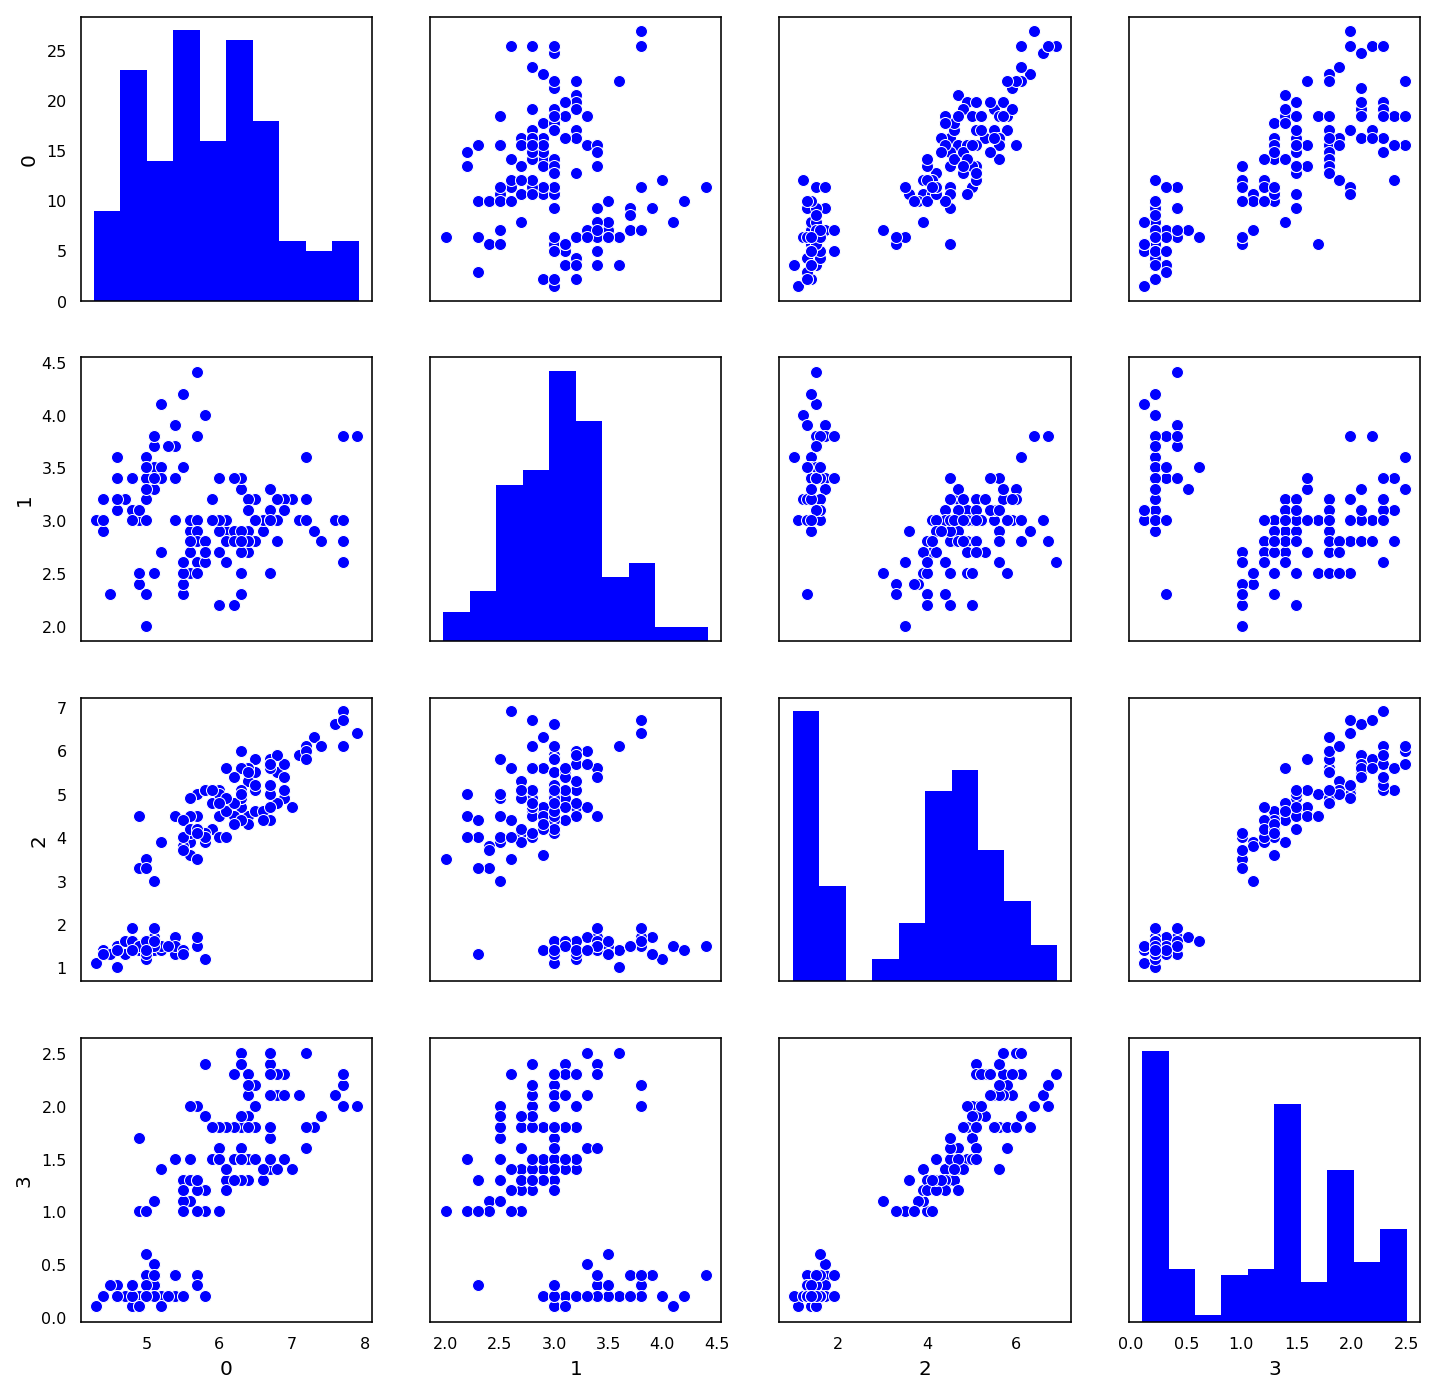

In [10]:
scatterplot_matrix([r[:-1] for r in data], target=False)

Well, it may not be as pretty as the matrix with a target variable, but useful nonetheless.

## Conclusion

And, that's going to bring us to the end of this lesson. The important takeaway here is not understanding every bit of code in the scatterplot matrix function above. In all honesty, it's better to use a library like [Seaborn][1], for instance, to create complex visualizations like the scatterplot matrix. But, rather, it's important to see just how easy it is to put something like our matrix function together using the relatively basic, but powerful, building blocks that matplotlib provides. Hopefully, this lesson will serve as some inspiration to you whenever you run into a need for a visualization that's not available right out of the box.

[1]: https://stanford.edu/~mwaskom/software/seaborn/examples/scatterplot_matrix.html